In [1]:
import sys
print(sys.executable)

c:\Users\91995\OneDrive\Desktop\New folder (2)\myenv\Scripts\python.exe


In [2]:
import os 
from PIL import Image 
import numpy as np 
import tensorflow as tf 

In [3]:
lr_dir = r"C:\Users\91995\Downloads\Urban100\Urban100\D6"
hr_dir = r"C:\Users\91995\Downloads\Urban100\Urban100\HR"

In [4]:
scale_size = 6
HR_SIZE = (1200, 1200)
LR_SIZE = (200, 200)
patch_size = 10  
stride = 5

In [6]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
def load_images_from_dir(directory, target_size=None):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path).convert('RGB')  
        img_array = np.array(img, dtype=np.uint8)  
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)  
        img_tensor = tf.cast(img_tensor, tf.float32) / 255.0  
        if target_size:
            img_tensor = tf.image.resize(img_tensor, target_size, method='area')  
        img_array = tf.cast(img_tensor * 255.0, tf.uint8).numpy()  
        img_yuv = cv2.cvtColor(img_array, cv2.COLOR_RGB2YUV)  
        images.append(img_yuv)  
    return np.array(images, dtype=np.uint8)

In [7]:
lr_images = load_images_from_dir(lr_dir, target_size=(200, 200))  
hr_images = load_images_from_dir(hr_dir, target_size=(1200, 1200)) 

In [8]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)  
    lr_image = tf.image.resize(input, [input_size, input_size], method="area") 
    return lr_image

def process_target(input):
    input = tf.image.rgb_to_yuv(input) 
    hr_image = tf.image.resize(input, HR_SIZE, method='bilinear')  
    return hr_image

def preprocess_image(data):
    hr_image = process_target(data) 
    lr_image = process_input(data, LR_SIZE[0], scale_size)  
    return lr_image, hr_image


def create_patches(image, patch_size, stride):
    print("Input shape to create_patches:", tf.shape(image))
    height = image.shape[1]
    if len(image.shape) == 2 and image.shape[1] == 3:
        image = tf.reshape(image, (10, 10, 3))  
    elif len(image.shape) == 3:
        image = tf.expand_dims(image, 0)
    
    #print("Adjusted input shape:", tf.shape(image))
    #image = tf.expand_dims(image, 0)  
    patches = tf.image.extract_patches(
        images=image,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, stride, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )
    patches = tf.reshape(patches, [-1, patch_size, patch_size, tf.shape(image)[-1]])  
    return patches


def apply_preprocessing_on_local_data(lr_images, hr_images):
    lr_patches_list = []
    hr_patches_list = []
    
    for lr_image, hr_image in zip(lr_images, hr_images):
        
        lr_image = tf.convert_to_tensor(lr_image, dtype=tf.float32) / 255.0
        hr_image = tf.convert_to_tensor(hr_image, dtype=tf.float32) / 255.0
        
        
        lr_processed, hr_processed = preprocess_image(hr_image)
        
        
        lr_patches = create_patches(lr_processed, patch_size, stride)
        hr_patches = create_patches(hr_processed, patch_size * scale_size, stride * scale_size)
        
        
        lr_patches_list.append(lr_patches)
        hr_patches_list.append(hr_patches)
    
    
    lr_patches = tf.concat(lr_patches_list, axis=0)
    hr_patches = tf.concat(hr_patches_list, axis=0)
    
    return lr_patches, hr_patches

In [9]:
lr_patches, hr_patches = apply_preprocessing_on_local_data(lr_images, hr_images)
#print("Low-res patches shape:", lr_patches.shape)
#print("High-res patches shape:", hr_patches.shape)

Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
Input shape to create_patches: tf.Tensor([1200 1200    3], shape=(3,), dtype=int32)
Input shap

In [10]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

class DepthToSpace(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

def leaky_relu_activation(x):
    leaky_relu_out = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    linear_out = x
    return leaky_relu_out + linear_out

class SinglePixelAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SinglePixelAttention, self).__init__(**kwargs)
        
    def call(self, inputs):
        mean_values = tf.reduce_mean(inputs, axis=-1)
        max_indices = tf.argmax(mean_values, axis=-1)
        attention_mask = tf.one_hot(max_indices, depth=tf.shape(inputs)[1])
        attention_mask = tf.expand_dims(attention_mask, axis=-1)
        attention_output = inputs * attention_mask
        return attention_output

In [11]:
def build_espcn_model_with_skip_connections(input_shape, scale_size):
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(16, 5, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv2 = tf.keras.layers.Conv2D(16, 3, padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(conv1)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)
    skip1 = tf.keras.layers.Add()([conv1, conv2])
    conv3 = tf.keras.layers.Conv2D(16, 2, padding='same', kernel_initializer='orthogonal')(skip1)
    conv3 = tf.keras.layers.Lambda(leaky_relu_activation)(conv3)
    conv3 = SinglePixelAttention()(conv3)
    skip2 = tf.keras.layers.Add()([skip1, conv3])
    conv4 = tf.keras.layers.Conv2D(3 * (scale_size ** 2), 3, padding='same', kernel_initializer='orthogonal')(skip2)
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv4)
    outputs = DepthToSpace(scale_size)(conv4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [12]:
input_shape = (patch_size, patch_size, 3)
espcn_model_with_skip_and_attention = build_espcn_model_with_skip_connections(input_shape, scale_size)
espcn_model_with_skip_and_attention.compile(optimizer='adam', loss='mse', metrics=[psnr])

c:\Users\91995\OneDrive\Desktop\New folder (2)\myenv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
espcn_model_with_skip_and_attention.fit(lr_patches, hr_patches, epochs=25)

Epoch 1/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0084 - psnr: 24.6880
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0015 - psnr: 30.9052
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0013 - psnr: 31.7731
Epoch 4/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0013 - psnr: 32.0516
Epoch 5/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0013 - psnr: 32.1988
Epoch 6/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0013 - psnr: 32.3177
Epoch 7/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0013 - psnr: 32.3669
Epoch 8/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0013 - psnr: 32.3809
Epoch 9/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0013 - psnr: 32.4134
Epoch 10/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0012 - psnr: 32.4546
Epoch 11/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0012 - psnr: 32.5032
Epoch 12/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/s

Input shape to create_patches: tf.Tensor([200 200   3], shape=(3,), dtype=int32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


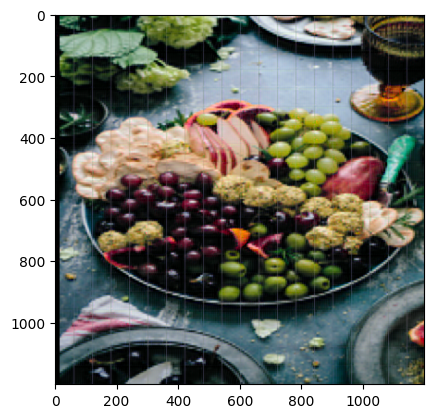

PSNR: 15.636275291442871 dB


In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and preprocess the image
img_dir = r"C:\Users\91995\Downloads\div2k\DIV2K_train_HR\DIV2Kcross6\0603.png"
image = Image.open(img_dir)
lr = np.array(image, dtype=np.float32)  # Convert to NumPy array with float32
lr = lr / 255.0  # Normalize the image

# Convert to YUV
img = tf.image.rgb_to_yuv(lr)

# Resize the image
img = tf.image.resize(img, (200, 200))

# Create patches (assuming create_patches is a custom function)
lr_patch = create_patches(img, 10, 5)  # Ensure create_patches is defined correctly

# Make predictions (assuming espcn_model_with_skip_and_attention is defined)
out = espcn_model_with_skip_and_attention.predict(lr_patch)

# Select every other patch
empt = [out[val] for val in range(len(out)) if val % 2 == 0]

# Convert patches back to RGB
empt_rgb = [tf.image.yuv_to_rgb(patch) for patch in empt]

# Convert the list of patches to a NumPy array
img = np.asarray(empt_rgb)

# Reshape the output image
tensor = tf.constant(img)
reshaped_img = tf.reshape(tensor, (20, 20, 60, 60, 3))
rearranged = tf.transpose(reshaped_img, perm=[0, 2, 1, 3, 4])
final = tf.reshape(rearranged, (20 * 60, 20 * 60, 3))

# Clip the values between 0 and 1 to avoid any issues with color overflow
final = tf.clip_by_value(final, 0.0, 1.0)

# Display the final image
plt.imshow(final.numpy())
plt.show()

# PSNR Calculation
# Load the original high-resolution image (resize it to match the final output size)
original_hr_image = Image.open(img_dir)
original_hr_image = original_hr_image.resize((20 * 60, 20 * 60))  # Ensure it's the same size as the final output
original_hr_image = np.array(original_hr_image, dtype=np.float32) / 255.0  # Normalize the image

# Convert original image to TensorFlow tensor
original_hr_image_tf = tf.convert_to_tensor(original_hr_image, dtype=tf.float32)

# Calculate PSNR between the original high-res image and the reconstructed final image
psnr_value = tf.image.psnr(original_hr_image_tf, final, max_val=1.0)
print(f"PSNR: {psnr_value.numpy()} dB")


In [ ]:
plt.imshow()